# **Modelamiento**

## Librerías

In [1]:
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
!pip install unidecode

     |████████████████████████████████| 235 kB 3.3 MB/s 


In [3]:
#Generales
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Proceso de Modelación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,median_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, ShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer

## Lectura Información

In [4]:
#Descargar datasets desde github
!git clone https://github.com/andres-soto-h/monografia-udea-eacd.git

Cloning into 'monografia-udea-eacd'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [5]:
#Lectura del dataset transformado
df_propiedades=pd.read_csv('/content/monografia-udea-eacd/df_prop_clean_12082021.csv', delimiter=';', encoding='latin1')

In [6]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd '/content/drive/My Drive/Colab Notebooks/Seminario/DATASETS'
# # !ls
# df_propiedades=pd.read_csv('df_prop_clean_12082021.csv', delimiter=';', encoding='latin1') 
# print(df_propiedades.shape)

In [7]:
df_propiedades.rename(columns={"municipio":"ubicacion"}, inplace=True)

**NOTA:** se decide eliminar la información del municipio de **La Unión**.

In [8]:
mask_union = df_propiedades['ubicacion']!='la uniÃ³n'
df_propiedades = df_propiedades[mask_union]

In [9]:
df_propiedades['ubicacion'].value_counts()

rionegro                  1241
el retiro                  439
la ceja                    342
guarne                     196
marinilla                  117
el carmen de viboral        62
san antonio de pereira      38
llanogrande                 31
santuario                   15
Name: ubicacion, dtype: int64

**Nota2:** Se convierte la variable Estrato en ordinal

In [10]:
df_propiedades['estrato'] = df_propiedades['estrato'].replace('Campestre', '0')
df_propiedades['estrato'] = df_propiedades['estrato'].astype(int)
df_propiedades['estrato'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4    947
5    636
3    584
0    162
6     89
2     58
1      5
Name: estrato, dtype: int64

## **Ajuste del Modelo**

**Funciones**

In [11]:
#Métricas datos transformados
def median_absolute_error2(y_true, y_pred):
  return median_absolute_error(np.expm1(y_true), np.expm1(y_pred))

def mean_squared_error2(y_true, y_pred):
  return mean_squared_error(np.expm1(y_true), np.expm1(y_pred), squared=False)


def mean_absolute_percentage_error2(y_true, y_pred):
  return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))
  
def r2_score2(y_true, y_pred):
  return r2_score(np.expm1(y_true), np.expm1(y_pred))

In [12]:
def div_train_test(X, y, var_stratify = ''):
  
  if var_stratify != '': 
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9, stratify = X[var_stratify],  random_state = 42)

    var_stratify_train = x_train[var_stratify]
    #ubicacion_test = X_test['ubicacion']

    x_train.drop(var_stratify,axis=1, inplace=True)
    x_test.drop(var_stratify,axis=1, inplace=True)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)

    return x_train, x_test, y_train, y_test, y_train_t, y_test_t, var_stratify_train

  else:
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9,  random_state = 42)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)
  
  return x_train, x_test, y_train, y_test, y_train_t, y_test_t

def busqueda_hiperparametros(x_train, y_train, var_stratify_train, estimator,param_grid = [] , scoring_med = 'neg_median_absolute_error', transf=False):

  if len(var_stratify_train) != 0:
    
    print('Seccion Stratify')
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
    stratified = sss.split(x_train, var_stratify_train)
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, cv = stratified, scoring = scoring_grid , refit = 'metrica',  return_train_score=True, n_jobs=-1, verbose=8)
    return grid.fit(x_train, y_train)
  
  else:
    print('OutStratify')
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, scoring = scoring_grid, refit = 'metrica', return_train_score=True, n_jobs=-1, verbose=8 )
    return grid.fit(X_train, y_train)

def metricas(model,y_train, p_train, y_test, p_test): 

  resultados = {
      'parametros' : [model.get_params()['steps'][1][1]],
      'MeAE_train' : [median_absolute_error(y_train,p_train)],
      'MeAE_test'  : [median_absolute_error(y_test, p_test)],
      'MAPE_train' : [mean_absolute_percentage_error(y_train,p_train)],
      'MAPE_test'  : [mean_absolute_percentage_error(y_test, p_test)],
      'r2_train'   : [r2_score(y_train,p_train)],
      'r2_test'    : [r2_score(y_test, p_test)],
      'rmse_train' : [mean_squared_error(y_train,p_train,squared = False)],
      'rmse_test'  : [mean_squared_error(y_test,p_test,squared = False)]
  }
  return pd.DataFrame(resultados)

**División Covariables  y Variable Objetivo**

In [13]:
data_model=df_propiedades.copy()
varibles_considerar = ['tipo','precio','area_m2','banos','garajes','antiguedad','estrato','ubicacion','tipo_propiedad','balcon','zonas_verdes','en_conjunto_cerrado','zona_infantil','supermercados_ccomerciales','colegios_universidades','trans_publico_cercano']
data_model = data_model.loc[:,varibles_considerar]
data_model.shape

(2481, 16)

In [14]:
X = data_model.drop(['precio'], axis=1)
y = data_model['precio']

**OneHotEncoder Variables Categóricas**

In [15]:
enc = OneHotEncoder(handle_unknown='ignore')
data_aux = pd.DataFrame(enc.fit_transform(X[['tipo','tipo_propiedad','ubicacion','antiguedad']]).toarray(), columns= enc.get_feature_names(['tipo','tipo_propiedad','ubicacion','antiguedad']))
data_aux['fila'] = range(0, X.shape[0])
data_aux.head()

X.drop(['tipo','tipo_propiedad','antiguedad'],axis=1,inplace=True)
X['fila'] = range(0, X.shape[0])

X = pd.merge(data_aux,X, on = 'fila', how='inner')
X.drop(['fila'], axis=1, inplace=True)
X.shape

(2481, 33)

_______________________________________________________________

Información de la columna **Descripción**

In [16]:
#Descargar stopwords español
!wget https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt

--2021-11-02 22:44:04--  https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4244 (4.1K) [text/plain]
Saving to: ‘spanish.txt’

spanish.txt         100%[===================>]   4.14K  --.-KB/s    in 0s      

2021-11-02 22:44:04 (37.8 MB/s) - ‘spanish.txt’ saved [4244/4244]



In [17]:
import re

data_text=pd.DataFrame(df_propiedades["descripcion"])
data_text

#Limpieza básica del texto
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.lower())
data_text['descripcion'] = data_text['descripcion'].apply((lambda x: re.sub(r'[0-9]+','',x)))

In [18]:
#Corregir error de encoding en textos

def replace_char(text):
  fix_text=text.replace('ã¡','a').replace('ã³','o').replace('ã±','ñ').replace('ã\x81','a').replace('ãº','u').replace('ã©','e').replace('ã\xad','i').replace('ã\x8d','i')
  return fix_text

data_text['descripcion'] = data_text['descripcion'].apply(replace_char)

Estematización o steaming ( realiza con algoritmos más sencillos utiliza el nltk ). Consultar como hacer el steaming con Español. La idea es llevar las palabras a su raiz. 

---



In [19]:
data_text['descripcion'] = data_text['descripcion'].apply((lambda x: re.sub(r'[^\w\s]','',x)))
data_text['descripcion'][0]

' vivari san nicolas es un conjunto residencial cerrado ubicado en el corazon de rionegro en el oriente antioqueño a pocos metros del centro comercial san nicolas con zonas recreacionales como piscinas para niños y adultos gimnasios cubiertos y al aire libre solarium un palmetto zona bbq zona de juegos zona de mascotas salon social y senderos peatonales lanzamiento apartamento modelo'

In [20]:
synopses = data_text['descripcion']

In [21]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
synopsesStem = []
for sentence in synopses:
     synopsesStem.append(" ".join([stemmer.stem(word) for word in sentence.split()]))
#define vectorizer parameters
count_vectorizer = CountVectorizer(max_df=1.0, max_features=200,
                                 min_df=0.1)

count_matrix = count_vectorizer.fit_transform(synopsesStem) #fit the vectorizer to synopses
count_vectorizer.get_feature_names()

['abiert',
 'acab',
 'acces',
 'agu',
 'al',
 'alcob',
 'ampli',
 'apartament',
 'are',
 'balcon',
 'bañ',
 'buen',
 'campestr',
 'cas',
 'cej',
 'centr',
 'cerc',
 'cerr',
 'closet',
 'cocin',
 'colegi',
 'comedor',
 'comercial',
 'comod',
 'con',
 'constru',
 'cuart',
 'cubiert',
 'cuent',
 'de',
 'del',
 'dos',
 'el',
 'en',
 'espaci',
 'esta',
 'estudi',
 'excelent',
 'finc',
 'garaj',
 'gas',
 'gimnasi',
 'habit',
 'habitacion',
 'hermos',
 'hor',
 'infantil',
 'integral',
 'jueg',
 'la',
 'las',
 'los',
 'lot',
 'mas',
 'minut',
 'muy',
 'nivel',
 'par',
 'parqu',
 'parqueader',
 'pati',
 'pis',
 'piscin',
 'por',
 'porteri',
 'principal',
 'public',
 'red',
 'retir',
 'rionegr',
 'rop',
 'sal',
 'salon',
 'san',
 'se',
 'sector',
 'servici',
 'social',
 'sol',
 'terraz',
 'tien',
 'tod',
 'tranquil',
 'transport',
 'ubic',
 'ubicacion',
 'un',
 'una',
 'unid',
 'util',
 'valor',
 'vend',
 'vent',
 'verd',
 'vesti',
 'vigil',
 'vist',
 'zon']

In [22]:
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("alcobas", "alcoba"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("closets", "closet"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplia", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplias", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplio", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplios", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("ampliars", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("zonas", "zona"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("apartamentos", "apto"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("apartamento", "apto"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("aptos", "apto"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("mt", "mts"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("metros cuadrados", "mts"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("m2", "mts"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("balcones", "balcon"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("baños", "baño"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("iglesias", "iglesia"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("espacio", "espacios"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("habitaciones", "habitacion"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("espacio", "espacios"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("niveles", "nivel"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("publico", "publicos"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("hermosa", "hermoso"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("hermosas", "hermoso"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("hermosos", "hermoso"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("ropas", "ropa"))

In [23]:
data_text['descripcion'][0]

' vivari san nicolas es un conjunto residencial cerrado ubicado en el corazon de rionegro en el oriente antioqueño a pocos metros del centro comercial san nicolas con zona recreacionales como piscinas para niños y adultos gimnasios cubiertos y al aire libre solarium un palmetto zona bbq zona de juegos zona de mascotas salon social y senderos peatonales lanzamiento apto modelo'

In [24]:
stopwords = pd.read_csv('spanish.txt', header = None, sep='\n')
stopwords_list = list(stopwords[0])

In [25]:
#define vectorizer parameters
count_vectorizer = CountVectorizer(max_features=500, stop_words=stopwords_list, ngram_range=(1,2))
count_matrix = count_vectorizer.fit_transform(data_text['descripcion']) 

print(count_matrix.shape)

(2481, 500)


In [26]:
count_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [27]:
labels=count_vectorizer.get_feature_names()
df_vectorizer= pd.DataFrame(count_matrix.toarray(), columns=labels)
df_vectorizer.head()

,abierta,abierta integral,acabados,acceso,acceso vias,acueducto,ademas,administracion,administracion predial,adultos,aeropuerto,aeropuerto internacional,agua,aire,aire libre,alcoba,alcoba alcoba,alcoba baño,alcoba closet,alcoba principal,alcoba servicio,alcoba vestier,alta,alta valorizacion,alto,ambiente,americana,ampliar,ampliar espaciosss,ampliar zona,antioqueño,antioquia,antonio,antonio pereira,anual,aprox,apto,apto ubicado,apto unidad,apto venta,...,vende,vendo,venta,venta apto,venta rionegro,venta sector,venta ubicada,venta ubicado,verde,verdes,verdes salon,vereda,vestier,vestier baño,vestier closet,via,via principal,vias,vias acceso,vias transporte,vicente,vigilancia,vigilancia horas,visitantes,vista,vista panoramica,viva,vivienda,vivir,whatsapp,zona,zona alta,zona bbq,zona comerciales,zona comunes,zona mascotas,zona residencial,zona ropa,zona verde,zona verdes
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0


In [28]:
df_vectorizer.rename(columns={'ubicacion':'ubicacion_v'}, inplace=True)

In [29]:
X_v = pd.concat([X,df_vectorizer], axis=1)

In [30]:
# y = data_model['precio']
# X = X_v.copy()
# X.reset_index(inplace=True)

In [31]:
# X.shape, y.shape

**División train y Test**

In [32]:
X_train, X_test, Y_train, Y_test, Y_train_t, Y_test_t, var_stratify_train = div_train_test(X, y, var_stratify = 'ubicacion')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train.head()

,tipo_Nueva,tipo_Usada,tipo_propiedad_apartaestudio,tipo_propiedad_apartamento,tipo_propiedad_casa,tipo_propiedad_finca,ubicacion_el carmen de viboral,ubicacion_el retiro,ubicacion_guarne,ubicacion_la ceja,ubicacion_llanogrande,ubicacion_marinilla,ubicacion_rionegro,ubicacion_san antonio de pereira,ubicacion_santuario,antiguedad_0,antiguedad_1 a 8 aÃ±os,antiguedad_16 a 30 aÃ±os,antiguedad_9 a 15 aÃ±os,antiguedad_Menos de 1 aÃ±o,antiguedad_MÃ¡s de 30 aÃ±os,area_m2,banos,garajes,estrato,balcon,zonas_verdes,en_conjunto_cerrado,zona_infantil,supermercados_ccomerciales,colegios_universidades,trans_publico_cercano
398,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2150.0,6.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
788,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,165.0,4.0,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1422,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,190.0,2.0,1.0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
119,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,800.0,2.0,0.0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1227,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3334.0,3.0,5.0,5,1.0,1.0,1.0,0.0,0.0,1.0,1.0


### **Red Neuronal**

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN, Embedding, Input

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)

In [35]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
# Removing Stop Words

from nltk.corpus import stopwords
all_sentences = data_text['descripcion'].values
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
#stop_words = stopwords.words('spanish')
#stop_words.append('')

#for i in range(len(all_words)):  
#    all_words[i] = [w for w in all_words[i] if (w not in stop_words) and (not w.isdigit())]

In [38]:
max_len=0
for sentence in all_words:  
  if len(sentence)>max_len:
    max_len = len(sentence)

max_len

173

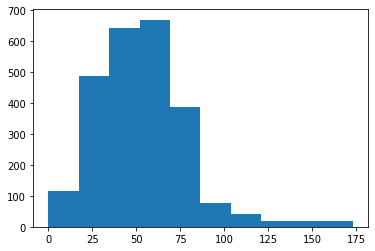

In [39]:
longitud = []

for sentence in all_words:  
  longitud.append(len(sentence))

plt.hist(longitud);

In [40]:
max_len=80

In [41]:
def get_preprocessed_seq(text_list):

    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer

    max_features = 500
    tokenizer = Tokenizer(num_words=max_features, split=',')
    
    tokenizer.fit_on_texts(text_list)
    X = tokenizer.texts_to_sequences(text_list)

    Xdata = tf.keras.preprocessing.sequence.pad_sequences(X, dtype='int32', truncating='post', maxlen= max_len, padding='post', value=0.0)

    return tokenizer, Xdata 


tokenizer, NewX = get_preprocessed_seq(all_words)

In [42]:
NewX_train=NewX[list(X_train.index.to_numpy())]
NewX_train.shape

(2232, 80)

In [47]:
def build_model2(cells_number=10):

    inp1 = Input(shape=(X_train_scaled.shape[1],), name="Input_Feautures")
    l11 = Dense(200, activation="relu", name="dense1")(inp1)
    l110 =Dropout(0.1)(l11)
    l12 = Dense(100, activation="relu", name="dense2")(l110)
    l120 =Dropout(0.1)(l12)
    l13 = Dense(50, activation="relu", name="dense3")(l12)
    l130 =Dropout(0.1)(l13)

    inp2 = Input(shape=(NewX_train.shape[1],), name="Input_Text")
    cc1 = Embedding(input_dim=(tokenizer.num_words+1), output_dim=32, mask_zero=True)(inp2)
    cc2 = LSTM(cells_number, return_sequences=False)(cc1)

    cc3 = tf.concat([l130, cc2],axis=1)
    cc4 = Dense(10, activation='relu', name="densa4")(cc3)
    cc5 = Dropout(0.1)(cc4)
    output = Dense(1)(cc5)
    
    model = Model(inputs=[inp1, inp2], outputs=output)
    
    optimizer = tf.keras.optimizers.Adam(
      learning_rate=0.002,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      name="Adam"
    )

    model.compile(loss='mean_absolute_percentage_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_percentage_error'])
  
    return model

In [48]:
model2 = build_model2(cells_number=100)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Feautures (InputLayer)    [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 200)          6600        Input_Feautures[0][0]            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 200)          0           dense1[0][0]                     
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 100)          20100       dropout_4[0][0]                  
____________________________________________________________________________________________

In [50]:
model2.fit([X_train_scaled, NewX_train], Y_train.to_numpy(), epochs=100)

Epoch 1/100
70/70 [==============================] - 6s 87ms/step - loss: 99.9007 - mean_absolute_percentage_error: 99.9007
Epoch 2/100
70/70 [==============================] - 6s 86ms/step - loss: 96.8012 - mean_absolute_percentage_error: 96.8012
Epoch 3/100
70/70 [==============================] - 6s 89ms/step - loss: 80.2934 - mean_absolute_percentage_error: 80.2934
Epoch 4/100
70/70 [==============================] - 6s 88ms/step - loss: 71.9123 - mean_absolute_percentage_error: 71.9123
Epoch 5/100
70/70 [==============================] - 6s 86ms/step - loss: 70.0120 - mean_absolute_percentage_error: 70.0120
Epoch 6/100
70/70 [==============================] - 6s 87ms/step - loss: 67.9424 - mean_absolute_percentage_error: 67.9424
Epoch 7/100
70/70 [==============================] - 6s 87ms/step - loss: 65.6262 - mean_absolute_percentage_error: 65.6262
Epoch 8/100
70/70 [==============================] - 6s 88ms/step - loss: 63.1068 - mean_absolute_percentage_error: 63.1068
Epoch 9/

####**Sin tranformar la Y**